In [1]:
import pandas as pd
import numpy as np
import os, sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.datasets import make_classification
from joblib import Parallel, delayed
import time
from glob import glob

In [2]:

def get_data(lab_file, method):
    fn = lab_file[:]
    fn = fn.replace('.txt', '_gvf.txt_impact_scores.txt.gz')
    fn = fn.replace('susie/', f'susie_vip/{method}/')
    X = pd.read_csv(fn, sep='\t')
    pick_cols = [True if '.bed' in i else False for i in X.columns]
    X = np.array(X.iloc[:,pick_cols])
    y = pd.read_csv(lab_file, sep='\t')
    y = np.array(y['causal'])
    return X, y
    

def eval_method(lab_file, method, n=50):
    X, y = get_data(lab_file, method)

    def evaluate_single_run(seed):
        clf = RandomForestClassifier(n_estimators=100, random_state=seed*10)
        #clf = SVC(random_state=seed*10)
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed*20)
        return cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    
    start_time = time.time()
    res = Parallel(n_jobs=-1)(delayed(evaluate_single_run)(i) for i in range(n))
    elapsed_time = time.time() - start_time

    res = np.stack(res)
    mean_result = np.nanmean(res)

    print(f"Mean ROC AUC: {mean_result}")
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

    return res


def eval_all(lab_files, method, n = 50):
    res_mean = []
    res_data = {}
    for fi in lab_files:
        print(f'testing: {fi}')
        res = eval_method(fi, method, n)
        res_mean.append(np.nanmean(res))
        tis = os.path.basename(fi).replace('susie_', '').replace('.txt', '')                                           
        res_data[tis] = res
    return res_mean, res_data

In [3]:
lab_files = glob('data/susie/*txt')

In [4]:
res_mean, res_data = eval_all(lab_files, 'pig_DanQ_keras')

testing: data/susie/susie_Lung.txt
Mean ROC AUC: 0.6017586081775534
Elapsed time: 58.18 seconds
testing: data/susie/susie_Testis.txt
Mean ROC AUC: 0.5541229340690457
Elapsed time: 292.90 seconds
testing: data/susie/susie_Adipose.txt
Mean ROC AUC: 0.558340996174497
Elapsed time: 216.41 seconds
testing: data/susie/susie_Uterus.txt
Mean ROC AUC: 0.5225653811999966
Elapsed time: 53.90 seconds
testing: data/susie/susie_Embryo.txt
Mean ROC AUC: 0.5707469696362761
Elapsed time: 50.53 seconds
testing: data/susie/susie_Ileum.txt
Mean ROC AUC: 0.551899816638571
Elapsed time: 29.76 seconds
testing: data/susie/susie_Spleen.txt
Mean ROC AUC: 0.7468730811097466
Elapsed time: 28.86 seconds
testing: data/susie/susie_Ovary.txt
Mean ROC AUC: 0.5895334701970838
Elapsed time: 50.84 seconds
testing: data/susie/susie_Small_intestine.txt
Mean ROC AUC: 0.5572394058760375
Elapsed time: 109.39 seconds
testing: data/susie/susie_Brain.txt
Mean ROC AUC: 0.5611058186646057
Elapsed time: 197.40 seconds
testing: data

In [5]:
import matplotlib.pyplot as plt

def barplot_from_dict(data_dict, xlabel='AUC', ylabel='Tissues', title='Mean and SD of AUC', output_file=None):
    keys = list(data_dict.keys())
    means = [np.mean(data_dict[key]) for key in keys]
    sds = [np.std(data_dict[key].mean(1)) for key in keys]

    plt.barh(keys, means, xerr=sds, capsize=5, color='skyblue', alpha=0.8)
    plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1)  # Add dashed line at x = 0.5
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
        print(f"Bar chart saved as {output_file}")
    else:
        plt.show()

Bar chart saved as out_figs/Fig4.pdf


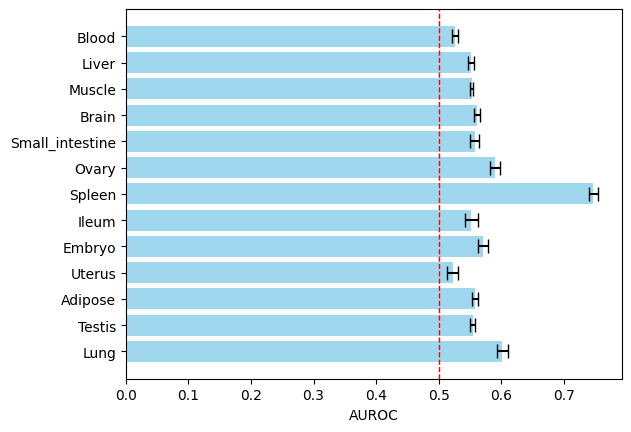

In [6]:
barplot_from_dict(res_data, xlabel='AUROC', ylabel='', 
                  title='', 
                  output_file='out_figs/Fig4.pdf')


In [7]:
res_mean = [np.mean(value) for key, value in res_data.items()]

In [8]:
np.mean(res_mean)

0.572594727896395

In [9]:
res_mean

[0.6017586081775534,
 0.5541229340690457,
 0.558340996174497,
 0.5225653811999966,
 0.5707469696362761,
 0.551899816638571,
 0.7468730811097466,
 0.5895334701970838,
 0.5572394058760375,
 0.5611058186646057,
 0.5526467932786059,
 0.5508112138710233,
 0.5260869737600922]

In [10]:
[key for key, value in res_data.items()]

['Lung',
 'Testis',
 'Adipose',
 'Uterus',
 'Embryo',
 'Ileum',
 'Spleen',
 'Ovary',
 'Small_intestine',
 'Brain',
 'Muscle',
 'Liver',
 'Blood']